# GPT-2 (124M)

We are going to reproduce the 124 million paramater GPT-2 model.

## Sample from model

In [ ]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)

generated_sequences = generator("Hello, I'm a language model,", truncation=True, max_length=30, num_return_sequences=5)

for i, sequence in enumerate(generated_sequences, start=1):
    print(f"{i}) {sequence['generated_text']}")

## Loading parameters

We are going to **load the parameters** of the GPT-2 (124M) model released by OpenAI using the [Hugging Face code](https://huggingface.co/openai-community/gpt2).

In [47]:
from transformers import GPT2LMHeadModel

model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
model_hf

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

*state_dict()* returns a dictionary containing the tensors

In [49]:
sd_hf = model_hf.state_dict()


print('%-40s %s' % ('Tensor:', 'Shape:'))
for k, v in sd_hf.items():
    print('%-40s %s' % (k, tuple(v.shape)))

Tensor:                                  Shape:
transformer.wte.weight                   (50257, 768)
transformer.wpe.weight                   (1024, 768)
transformer.h.0.ln_1.weight              (768,)
transformer.h.0.ln_1.bias                (768,)
transformer.h.0.attn.c_attn.weight       (768, 2304)
transformer.h.0.attn.c_attn.bias         (2304,)
transformer.h.0.attn.c_proj.weight       (768, 768)
transformer.h.0.attn.c_proj.bias         (768,)
transformer.h.0.ln_2.weight              (768,)
transformer.h.0.ln_2.bias                (768,)
transformer.h.0.mlp.c_fc.weight          (768, 3072)
transformer.h.0.mlp.c_fc.bias            (3072,)
transformer.h.0.mlp.c_proj.weight        (3072, 768)
transformer.h.0.mlp.c_proj.bias          (768,)
transformer.h.1.ln_1.weight              (768,)
transformer.h.1.ln_1.bias                (768,)
transformer.h.1.attn.c_attn.weight       (768, 2304)
transformer.h.1.attn.c_attn.bias         (2304,)
transformer.h.1.attn.c_proj.weight       (768, 768

## Position embeddings

In the plot below, every row is a different fixed absloute position in the range from 0 to 1024 (block_size). We can notice the position embeddings seem to have structure because they end up learning the sines and cosines that represent each of these positions. Thus, the Transformer relizes which token is where and attend to them depending on their position, not just their content.

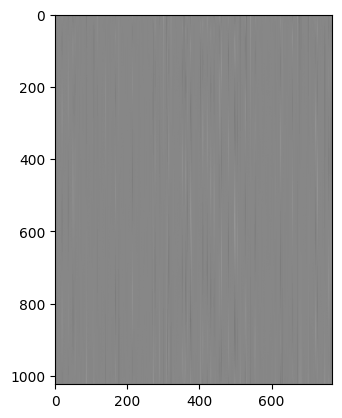

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray");

In the original transformer from the [*Attention is all you need*](https://arxiv.org/abs/1706.03762) paper, the positional embeddings are initialized and fixed to sinusoids and cosiness of different frequencies. However, in the GPT-2 model, the positional embedding are initialized and trained like any other parameter. In the plot below, we can see how different channels respond more or less to different positions and look for the most part sinusoidal. The fact that they are kind of noisy means this model was not fully trained.

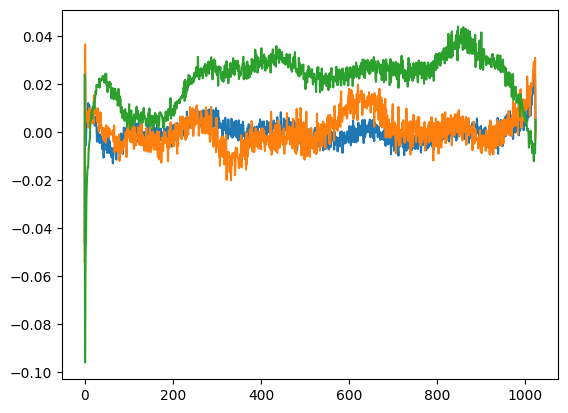

In [56]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 150])   # channel 150
plt.plot(sd_hf["transformer.wpe.weight"][:, 200])   # channel 200
plt.plot(sd_hf["transformer.wpe.weight"][:, 250]);  # channel 250

## GPT-2 architecture

The original transformer from the [*Attention Is All You Need*](https://arxiv.org/abs/1706.03762) paper is an **encoder-decoder transformer**, and has the following architecture:

<div style="width: 450px">
    <img src="https://www.jeremyjordan.me/content/images/2023/05/transformer-architecture.png">
</div>

<br>

GPT-2 is a **decoder only transformer** so the entire encoder block and the cross-attention are missing. In addition, the normalization layers are applied before the tranformations, and a normalization layer is added after the final self-attention block.

## GPT Class

The class GPT inherits from [**nn.Module**](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), a base class in PyTorch that provides important functionalities, such as:
- Managing parameters (e.g., weights, biases).
- Defining the forward pass.
- Interacting with optimizers and handling gradients.

The PyTorch container [**nn.ModuleDict**](https://pytorch.org/docs/stable/generated/torch.nn.ModuleDict.html) is used to hold submodules (layers) in a single attribute (in this case, self.transformer), where each submodules can be indexed using a key. It is useful for organizing modules that are part of a larger model.

The PyTorch container [**nn.ModuleList**](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html), is similar to nn.ModuleDict, but it is used to hold a list of submodules, where each module can be indexed using an integer. It is useful when you have a variable number of modules that need to be stored and managed together.

<br>

**Note:** *super().\_\_init\_\_()* calls the constructor of the parent class (in this case, nn.Module).

**Note:** The *@dataclass* decorator automatically generates the special methods:
- *\_\_init\_\_()* which initializes the class attributes.
- *\_\_repr\_\_()* which provides a string representation of the object.
- *\_\_eq\_\_()* which allows equality comparison.

In [101]:
from dataclasses import dataclass
import torch.nn as nn

@dataclass
class GPTConfig:
    block_size: int = 1024  # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12       # number of layers
    n_head: int = 12        # number of heads
    n_embd: int = 768       # embedding dimension


# ----------------------------------------------------------------------------------------------


class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),               # token embeddings weights
            wpe = nn.Embedding(config.block_size, config.n_embd),               # position embeddings weights
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),  
            ln_f = nn.LayerNorm(config.n_embd),                                 # final normalization layer
        ))

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)  # final classifier
        
        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)


## Block class

In the [*Attention Is All You Need*](https://arxiv.org/abs/1706.03762) paper, the **layer normalizations** are after the application of attention and feed forward. In addition, the normalizations are inside the residual pathway. It is preferible to have a single clean residual stream all the way down from supervison to the inputs.

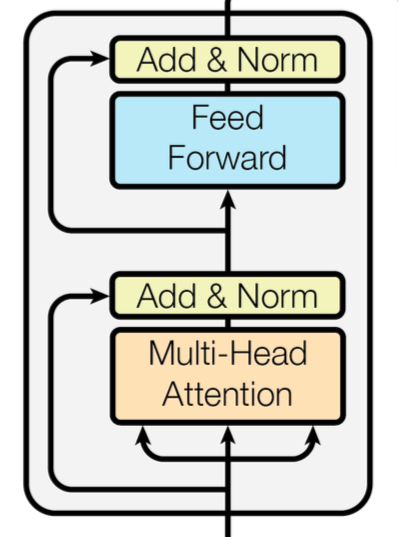

In [ ]:
class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd) # layer normalization 1
        self.attn = CausalSelfAttention(config) 
        self.ln_2 = nn.LayerNorm(config.n_embd) # layer normalization 2
        self.mlp = MLP(config)                  # feed forward network (FFN)
    
    def forward(self, x):
        x = x + self.attn(self.ln_1(x)) # pre-normalization before attention 
        x = x + self.mlp(self.ln_2(x))  # pre-normalization before FFN
        return x

## Attention class

In [ ]:
class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True) # flash attention
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y

# MLP class (FFN)

[GELU](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) is a non-linear activation function introduced in the paper [Gaussian Error Linear Units (GELUs)](https://arxiv.org/abs/1606.08415). It is very similar to [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), but with a smoother curve, especially at 0, avoiding the "dead neuron" problem that ReLU can suffer from. This issue arises when ReLU sets any negative input to zero, causing a zero gradient and halting learning for those neurons. Instead of having a flat region like ReLU, GELU uses a probabilistic approach to allow small negative values to pass through with some probability, enabling small gradients to flow usually leading to a more robust training and better network performance.

<div style="display: flex; justify-content: center;">
    <div style="width: 500px;">
        <img src="https://pytorch.org/docs/stable/_images/ReLU.png">
    </div>
    <div style="width: 500px;">
        <img src="https://pytorch.org/docs/stable/_images/GELU.png">
    </div>
</div>

In [ ]:
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd) # linear layer
        self.gelu    = nn.GELU(approximate='tanh')                 # GELU non-linearity
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd) # linear layer
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

In [ ]:
# let's instead sample manually
import torch
from torch.nn import functional as F

model = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
model.eval()
model.to('cuda')
torch.manual_seed(42)
torch.cuda.manual_seed(42)
tokens = [15496, 11, 314, 1101, 257, 3303, 2746, 11] # "Hello, I'm a language model,"
tokens = torch.tensor(tokens, dtype=torch.long) # (8,)
tokens = tokens.unsqueeze(0).repeat(5, 1) # (5, 8)
x = tokens.to('cuda')

# generate!
while x.size(1) < 30: # max_length=30
    # forward the model to get the logits
    with torch.no_grad():
        logits = model(x)[0] # (B, T, vocab_size)
        # take the logits at the last position
        logits = logits[:, -1, :] # (B, vocab_size)
        # get the probabilities
        probs = F.softmax(logits, dim=-1)
        # do top-k sampling of 50 (huggingface pipeline default)
        # topk_probs here becomes (5, 50), topk_indices is (5, 50)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilities
        # note: multinomial does not demand the input to sum to 1
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        # append to the sequence
        x = torch.cat((x, xcol), dim=1)

# print the generated text
import tiktoken
enc = tiktoken.get_encoding('gpt2')
for i in range(5):
    tokens = x[i, :30].tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)

In [ ]:
# tiny shakespeare dataset
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r') as f:
    text = f.read()
data = text[:1000] # first 1,000 characters
print(data[:100])

In [ ]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(data)
print(tokens[:24])

In [ ]:
import torch
buf = torch.tensor(tokens[:24 + 1])
x = buf[:-1].view(4, 6)
y = buf[1:].view(4, 6)
print(x)
print(y)

In [ ]:
print(sd_hf["lm_head.weight"].shape)
print(sd_hf["transformer.wte.weight"].shape)

In [ ]:
(sd_hf["lm_head.weight"] == sd_hf["transformer.wte.weight"]).all()

In [ ]:
print(sd_hf["lm_head.weight"].data_ptr())
print(sd_hf["transformer.wte.weight"].data_ptr())

In [ ]:

# standard deviation grows inside the residual stream
x = torch.zeros(768)
n = 100 # e.g. 100 layers
for i in range(n):
    x += n**-0.5 * torch.randn(768)

print(x.std())

In [ ]:
import torch

# super simple little MLP
net = torch.nn.Sequential(
    torch.nn.Linear(16, 32),
    torch.nn.GELU(),
    torch.nn.Linear(32, 1)
)
torch.random.manual_seed(42)
x = torch.randn(4, 16)
y = torch.randn(4, 1)
net.zero_grad()
yhat = net(x)
loss = torch.nn.functional.mse_loss(yhat, y)
loss.backward()
print(net[0].weight.grad.view(-1)[:10])

# the loss objective here is (due to readuction='mean')
# L = 1/4 * [
#            (y[0] - yhat[0])**2 +
#            (y[1] - yhat[1])**2 +
#            (y[2] - yhat[2])**2 +
#            (y[3] - yhat[3])**2
#           ]
# NOTE: 1/4!

In [ ]:
# now let's do it with grad_accum_steps of 4, and B=1
# the loss objective here is different because
# accumulation in gradient <---> SUM in loss
# i.e. we instead get:
# L0 = 1/4(y[0] - yhat[0])**2
# L1 = 1/4(y[1] - yhat[1])**2
# L2 = 1/4(y[2] - yhat[2])**2
# L3 = 1/4(y[3] - yhat[3])**2
# L = L0 + L1 + L2 + L3
# NOTE: the "normalizer" of 1/4 is lost
net.zero_grad()
for i in range(4):
    yhat = net(x[i])
    loss = torch.nn.functional.mse_loss(yhat, y[i])
    loss = loss / 4 # <-- have to add back the "normalizer"!
    loss.backward()
print(net[0].weight.grad.view(-1)[:10])


In [ ]:
# parse and visualize the logfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # HellaSwag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

# load the log file
with open("log124M_40B/log.txt", "r") as f:
    lines = f.readlines()

# parse the individual lines, group by stream (train,val,hella)
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

# convert each stream from {step: val} to (steps[], vals[])
# so it's easier for plotting
streams_xy = {}
for k, v in streams.items():
    # get all (step, val) items, sort them
    xy = sorted(list(v.items()))
    # unpack the list of tuples to tuple of lists
    streams_xy[k] = list(zip(*xy))

# create figure
plt.figure(figsize=(16, 6))

# Panel 1: losses: both train and val
plt.subplot(121)
xs, ys = streams_xy["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"] # validation loss
plt.plot(xs, ys, label=f'nanogpt ({sz}) val loss')
# horizontal line at GPT-2 baseline
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag eval
plt.subplot(122)
xs, ys = streams_xy["hella"] # HellaSwag eval
ys = np.array(ys)
plt.plot(xs, ys, label=f"nanogpt ({sz})")
# horizontal line at GPT-2 baseline
if hella2_baseline:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
if hella3_baseline:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")
print("Max Hellaswag eval:", max(ys))